![Colegio Bourbaki](./Images/Bourbaki.png)

# Machine Learning & AI

### Red convolucional de grafos ponderados geográficamente (Geographically Weighted Graph Convolutional Network)

Una Red Convolucional de Grafos Ponderados Geográficamente (GCN por sus siglas en inglés, Geographically Weighted Graph Convolutional Network) es una extensión de las redes convolucionales de grafos que incorpora información espacial y geográfica en el análisis de datos que tienen una estructura de grafo. A diferencia de las redes convolucionales tradicionales, que se aplican a datos organizados en forma de cuadrícula (como imágenes), las GCN están diseñadas para procesar datos en forma de grafos, donde los nodos y sus conexiones representan relaciones complejas.

**Introducción a los Grafos Ponderados Geográficamente**

En un grafo ponderado geográficamente, las aristas no solo representan conexiones entre nodos, sino que también incluyen pesos que reflejan distancias geográficas, similitudes espaciales, o relaciones geográficas específicas. Este tipo de modelado es útil en contextos donde la proximidad geográfica influye en las interacciones, como en análisis de transporte, estudios ambientales, o redes sociales con datos geolocalizados.
Red Convolucional de Grafos Ponderados Geográficamente

Las Redes Convolucionales de Grafos Ponderados Geográficamente combinan la capacidad de las GCN para capturar la estructura topológica del grafo con el uso de pesos geográficos para ajustar las contribuciones de los nodos vecinos. La idea es incorporar información espacial de manera explícita en el proceso de aprendizaje, lo que permite:

* Modelar influencias geográficas entre los nodos.
* Capturar patrones espaciales que no son evidentes en grafos no ponderados.
* Mejorar la precisión en tareas como clasificación de nodos, predicción de enlaces o regresión de atributos nodales.

**Aplicaciones**

* Transporte y movilidad: Predicción de tráfico o demanda de transporte público, considerando la proximidad geográfica entre estaciones o puntos de interés.
* Análisis ambiental: Modelado de fenómenos naturales, como la calidad del aire o la contaminación, utilizando datos geoespaciales.
* Redes sociales: Análisis de interacciones entre usuarios considerando tanto la estructura de la red como su localización geográfica.

En conclusión, las Redes Convolucionales de Grafos Ponderados Geográficamente ofrecen una poderosa herramienta para integrar información geográfica y espacial en el análisis de datos complejos estructurados como grafos, lo que permite mejorar la precisión de los modelos y capturar relaciones espaciales relevantes.


#### Contexto

Utilizaremos un dataset de propiedades de Airbnb en la zona de San Diego, California, USA. El dataset se encuentra en formato GEOJSON.

![Colegio Bourbaki](./Images/Data.png)

#### Librerias

In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gp
import seaborn as sns
import torch
from pysal.lib import weights
from scipy import sparse, stats
from scipy.sparse import coo_matrix, csr_matrix, diags, eye, csgraph
from scipy.spatial import distance
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse, median_absolute_error as mae
from sklearn.neighbors import NearestNeighbors
from torch import nn
import torch.nn.functional as F

import esda
from typing import Tuple, List, Dict

#### Funciones de ayuda

In [2]:
def mkdir(path: str) -> None:
    """
    Create a directory if it does not exist.

    Args:
        path (str): The directory path to create.

    Raises:
        OSError: If the directory cannot be created and does not already exist.
    """
    if not os.path.exists(path):
        try:
            os.makedirs(path)
            print(f"Directory created at: {path}")
        except OSError as e:
            raise OSError(f"Failed to create directory {path}: {e}")
    else:
        print("--- A folder with the same name already exists! ---")

In [3]:
def row_normalize(mx: sparse.spmatrix) -> sparse.spmatrix:
    """
    Row-normalize a sparse matrix.

    Each row of the matrix will sum to 1. Rows with a sum of 0 are left unchanged.

    Args:
        mx (sparse.spmatrix): The sparse matrix to normalize.

    Returns:
        sparse.spmatrix: The row-normalized sparse matrix.

    Raises:
        TypeError: If the input is not a scipy sparse matrix.
    """
    if not sparse.isspmatrix(mx):
        raise TypeError("Input matrix must be a scipy sparse matrix.")

    rowsum = np.array(mx.sum(axis=1)).flatten()
    r_inv = np.power(rowsum, -1, where=rowsum != 0)
    r_inv[np.isinf(r_inv)] = 0.0
    r_mat_inv = diags(r_inv)
    normalized_mx = r_mat_inv.dot(mx)
    return normalized_mx

In [4]:
def unlog(x: float) -> float:
    """
    Return 10 raised to the power of x.

    Args:
        x (float): The exponent.

    Returns:
        float: 10^x.
    """
    return 10**x

In [5]:
def check_symmetric(a: np.ndarray, tol: float = 1e-8) -> bool:
    """
    Check if a matrix is symmetric within a specified tolerance.

    Args:
        a (np.ndarray): The matrix to check.
        tol (float, optional): Tolerance for symmetry. Defaults to 1e-8.

    Returns:
        bool: True if the matrix is symmetric within the tolerance, False otherwise.
    """
    if not isinstance(a, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    return bool(np.all(np.abs(a - a.T) < tol))

In [6]:
def make_sym_matrix_boolean_sum(mx: np.ndarray) -> np.ndarray:
    """
    Make a symmetric adjacency matrix by taking the boolean OR of the matrix and its transpose.

    This ensures the adjacency matrix is symmetric regardless of the original definition.

    Args:
        mx (np.ndarray): The original adjacency matrix.

    Returns:
        np.ndarray: The symmetric adjacency matrix.
    """
    if not isinstance(mx, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    return (mx + mx.T > 0).astype(int)

In [7]:
def renormalized_trick_mx(mx: np.ndarray) -> np.ndarray:
    """
    Add self-connections to the adjacency matrix by adding an identity matrix.

    Args:
        mx (np.ndarray): The original adjacency matrix.

    Returns:
        np.ndarray: The adjacency matrix with self-connections.
    """
    if not isinstance(mx, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    identity = np.eye(mx.shape[0], dtype=mx.dtype)
    return mx + identity

In [8]:
def renormalized_trick_laplacian_old(mx: np.ndarray) -> np.ndarray:
    """
    Compute the renormalized Laplacian matrix using SciPy's csgraph.

    This computes D~^(-1/2) A~ D~^(-1/2), where A~ is the adjacency matrix with added self-connections.

    Args:
        mx (np.ndarray): The adjacency matrix with self-connections.

    Returns:
        np.ndarray: The renormalized Laplacian matrix.
    """
    if not isinstance(mx, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    laplacian = csgraph.laplacian(mx, normed=True)
    identity = np.eye(mx.shape[0], dtype=mx.dtype)
    return identity - laplacian

In [9]:
def renormalized_trick_laplacian(mx_tilde: np.ndarray) -> np.ndarray:
    """
    Compute the renormalized Laplacian matrix D~^(-1/2) A~ D~(-1/2).

    Args:
        mx_tilde (np.ndarray): The adjacency matrix with self-connections.

    Returns:
        np.ndarray: The renormalized Laplacian matrix.
    """
    if not isinstance(mx_tilde, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    degree_tilde = np.diag(np.sum(mx_tilde, axis=1))
    try:
        D_tilde_inv_sqrt = np.linalg.inv(np.sqrt(degree_tilde))
    except np.linalg.LinAlgError:
        raise ValueError("Degree matrix is singular and cannot be inverted.")
    return D_tilde_inv_sqrt @ mx_tilde @ D_tilde_inv_sqrt

In [10]:
def prepare_adjacency_matrix(
    db: gpd.GeoDataFrame, k: int = 20
) -> Tuple[torch.Tensor, Dict]:
    """
    Create and normalize the adjacency matrix using K-Nearest Neighbors.

    Args:
        db (gpd.GeoDataFrame): The GeoDataFrame containing spatial data with a 'geometry' column.
        k (int, optional): Number of nearest neighbors. Defaults to 20.

    Returns:
        torch.Tensor: The normalized Laplacian adjacency matrix as a PyTorch tensor on the specified device.
    """
    knn = weights.KNN.from_dataframe(db, geom_col="geometry", k=k)
    A_knn = make_sym_matrix_boolean_sum(knn.full()[0])
    A_tilde = renormalized_trick_mx(A_knn)
    Laplacian = renormalized_trick_laplacian(A_tilde)
    return torch.FloatTensor(Laplacian), knn

In [11]:
def step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
) -> float:
    """
    Perform a training step with the given model and optimizer.

    Trains the model on the specified indices using Mean Squared Error loss.

    Args:
        model (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices of the training samples.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.

    Returns:
        float: The mean loss value for the training step.
    """
    model.train()
    optimizer.zero_grad(set_to_none=True)
    output = model(input_tensor, adj)
    loss = F.mse_loss(output[idx], target_tensor[idx], reduction="none").mean()
    loss.backward()
    optimizer.step()
    return loss.item()

In [12]:
def evaluate(
    model: nn.Module,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
) -> float:
    """
    Evaluate the model's performance on a validation set using Mean Squared Error.

    Args:
        model (nn.Module): The neural network model to evaluate.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices of the validation samples.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.

    Returns:
        float: The mean MSE loss on the validation set.
    """
    model.eval()
    with torch.no_grad():
        output = model(input_tensor, adj)
        loss = F.mse_loss(output[idx], target_tensor[idx], reduction="none").mean()
    return loss.item()

In [13]:
# def evaluate_MAE(
#     model: nn.Module,
#     input_tensor: torch.Tensor,
#     idx: torch.Tensor,
#     target_tensor: torch.Tensor,
#     adj: torch.Tensor,
# ) -> float:
#     """
#     Evaluate the model's performance on a validation set using Mean Absolute Error.

#     Args:
#         model (nn.Module): The neural network model to evaluate.
#         input_tensor (torch.Tensor): The input feature tensor.
#         idx (torch.Tensor): The indices of the validation samples.
#         target_tensor (torch.Tensor): The target tensor.
#         adj (torch.Tensor): The adjacency matrix tensor.

#     Returns:
#         float: The mean MAE on the validation set.
#     """
#     model.eval()
#     with torch.no_grad():
#         output = model(input_tensor, adj)
#         loss = F.l1_loss(output[idx], target_tensor[idx], reduction="none").mean()
#     return loss.item()

def evaluate_error(
    model: nn.Module,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
    error_type: str,
) -> float:
    """
    Evaluate the model's performance on a validation set using a user defined rror.

    Args:
        model (nn.Module): The neural network model to evaluate.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices of the validation samples.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.
        error_type(str): The error type to use. Can be "MSE" or "MAPE".

    Returns:
        float: The mean MAPE on the validation set.
    """
    model.eval()
    with torch.no_grad():
        if error_type == "MSE":
            output = model(input_tensor, adj)
            error = (
                F.mse_loss(output[idx], target_tensor[idx], reduction="none")
                / target_tensor[idx]
            ).mean()
        elif error_type == "MAPE":
            output = model(input_tensor, adj)
            error = (
                F.l1_loss(output[idx], target_tensor[idx], reduction="none")
                / target_tensor[idx]
            ).mean()
        else:
            raise ValueError("Invalid error type. Must be 'MSE' or 'MAPE'.")
    return error.item()

In [14]:
def return_results(
    model: nn.Module,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate and return the model's predictions and corresponding targets.

    Args:
        model (nn.Module): The trained neural network model.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices for which to generate predictions.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the predicted values and the ground truth values as NumPy arrays.
    """
    model.eval()
    with torch.no_grad():
        output = model(input_tensor, adj)
        predictions = output[idx].cpu().detach().numpy()
        targets = target_tensor[idx].cpu().detach().numpy()
    return predictions, targets

In [15]:
class GraphConvolution(nn.Module):
    """
    Basic graph convolution layer that incorporates both spatially lagged features.

    This layer performs the operation: H = activation(A * X * W + b)

    Attributes:
        f_in (int): Number of input features.
        f_out (int): Number of output features.
        use_bias (bool): Whether to include a bias term.
        activation (nn.Module): Activation function to apply.
        weight (nn.Parameter): Weight matrix.
        bias (nn.Parameter or None): Bias vector.
    """

    def __init__(
        self,
        f_in: int,
        f_out: int,
        use_bias: bool = True,
        activation: nn.Module = nn.ReLU(),
    ):
        """
        Initialize the GraphConvolution layer.

        Args:
            f_in (int): Number of input features.
            f_out (int): Number of output features.
            use_bias (bool, optional): Whether to include a bias term. Defaults to True.
            activation (nn.Module, optional): Activation function. Defaults to nn.ReLU().
        """
        super(GraphConvolution, self).__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation

        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out))
        if self.use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(f_out))
        else:
            self.register_parameter("bias", None)

        self.initialize_weights()

    def initialize_weights(self) -> None:
        """
        Initialize the weights and biases of the layer.

        Weights are initialized to ones, and biases are initialized to zeros if used.
        """
        nn.init.constant_(self.weight, 1.0)
        if self.use_bias:
            nn.init.constant_(self.bias, 0.0)

    def forward(self, input: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the graph convolution layer.

        Args:
            input (torch.Tensor): Input feature matrix of shape (N, f_in).
            adj (torch.Tensor): Adjacency matrix of shape (N, N).

        Returns:
            torch.Tensor: Output feature matrix of shape (N, f_out).
        """
        support = torch.mm(input, self.weight)
        out = torch.mm(adj, support)  # adj should be pre-normalized

        if self.use_bias:
            out += self.bias
        if self.activation is not None:
            out = self.activation(out)
        return out

#### Modelos

In [16]:
class GCN(nn.Module):
    """
    Graph Convolutional Network (GCN) model.

    This model consists of multiple GraphConvolution layers followed by an output layer.

    Attributes:
        layers (nn.Sequential): Sequence of hidden GraphConvolution layers.
        dropouts (List[float]): List of dropout rates for each hidden layer.
        out_layer (GraphConvolution): The final output graph convolution layer.
    """

    def __init__(
        self,
        f_in: int,
        n_classes: int,
        hidden: List[int] = [16],
        dropouts: List[float] = [0.0],
    ):
        """
        Initialize the GCN model.

        Args:
            f_in (int): Number of input features.
            n_classes (int): Number of output classes/features.
            hidden (List[int], optional): List containing the number of hidden units for each hidden layer. Defaults to [16].
            dropouts (List[float], optional): List containing dropout rates for each hidden layer. Defaults to [0.0].

        Raises:
            ValueError: If the lengths of hidden and dropouts lists do not match.
        """
        super(GCN, self).__init__()
        if len(hidden) != len(dropouts):
            raise ValueError("Length of hidden and dropouts lists must match.")

        self.layers = nn.Sequential()
        for i, (f_in_layer, f_out_layer) in enumerate(
            zip([f_in] + hidden[:-1], hidden)
        ):
            self.layers.add_module(
                f"GraphConvolution_{i}", GraphConvolution(f_in_layer, f_out_layer)
            )

        self.dropouts = dropouts
        self.out_layer = GraphConvolution(
            hidden[-1], n_classes, activation=None
        )  # No activation in output layer

    def forward(self, x: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GCN model.

        Args:
            x (torch.Tensor): Input feature matrix of shape (N, f_in).
            adj (torch.Tensor): Adjacency matrix of shape (N, N).

        Returns:
            torch.Tensor: Output feature matrix of shape (N, n_classes).
        """
        for i, layer in enumerate(self.layers):
            x = layer(x, adj)
            if self.dropouts[i] > 0:
                x = F.dropout(x, self.dropouts[i], training=self.training)

        x = self.out_layer(x, adj)
        return x


class GWGraphConvolution(nn.Module):
    """
    Geographically Weighted Graph Convolution layer.

    This layer incorporates locally parameterized weights for each feature.

    Attributes:
        f_in (int): Number of input features.
        f_out (int): Number of output features.
        use_bias (bool): Whether to include a bias term.
        activation (nn.Module): Activation function to apply.
        gwr_weight (nn.Parameter): Geographically weighted parameter vector.
        weight (nn.Parameter): Weight matrix.
        bias (nn.Parameter or None): Bias vector.
    """

    def __init__(
        self,
        f_in: int,
        f_out: int,
        use_bias: bool = True,
        activation: nn.Module = nn.ReLU(),
    ):
        """
        Initialize the GWGraphConvolution layer.

        Args:
            f_in (int): Number of input features.
            f_out (int): Number of output features.
            use_bias (bool, optional): Whether to include a bias term. Defaults to True.
            activation (nn.Module, optional): Activation function. Defaults to nn.ReLU().
        """
        super(GWGraphConvolution, self).__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation

        # Locally parameterized weights
        self.gwr_weight = nn.Parameter(torch.FloatTensor(f_in))
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out))
        if self.use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(f_out))
        else:
            self.register_parameter("bias", None)

        self.initialize_weights()

    def initialize_weights(self) -> None:
        """
        Initialize the weights and biases of the layer.

        GWR weights and standard weights are initialized to ones, and biases are initialized to zeros if used.
        """
        nn.init.constant_(self.weight, 1.0)
        nn.init.constant_(self.gwr_weight, 1.0)
        if self.use_bias:
            nn.init.constant_(self.bias, 0.0)

    def forward(self, input: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GWGraphConvolution layer.

        Args:
            input (torch.Tensor): Input feature matrix of shape (N, f_in).
            adj (torch.Tensor): Adjacency matrix of shape (N, N).

        Returns:
            torch.Tensor: Output feature matrix of shape (N, f_out).
        """
        gwr_support = input * self.gwr_weight.unsqueeze(
            0
        )  # Element-wise multiplication
        support = torch.mm(adj, gwr_support)
        out = torch.mm(support, self.weight)

        if self.use_bias:
            out += self.bias
        if self.activation is not None:
            out = self.activation(out)
        return out


class GWGCN(nn.Module):
    """
    Geographically Weighted Graph Convolutional Network (GWGCN) model.

    This model consists of multiple GWGraphConvolution layers followed by an output layer.

    Attributes:
        layers (nn.Sequential): Sequence of hidden GWGraphConvolution layers.
        dropouts (List[float]): List of dropout rates for each hidden layer.
        out_layer (GWGraphConvolution): The final output GWGraphConvolution layer.
    """

    def __init__(
        self,
        f_in: int,
        n_classes: int,
        hidden: List[int] = [16],
        dropouts: List[float] = [0.0],
    ):
        """
        Initialize the GWGCN model.

        Args:
            f_in (int): Number of input features.
            n_classes (int): Number of output classes/features.
            hidden (List[int], optional): List containing the number of hidden units for each hidden layer. Defaults to [16].
            dropouts (List[float], optional): List containing dropout rates for each hidden layer. Defaults to [0.0].

        Raises:
            ValueError: If the lengths of hidden and dropouts lists do not match.
        """
        super(GWGCN, self).__init__()
        if len(hidden) != len(dropouts):
            raise ValueError("Length of hidden and dropouts lists must match.")

        self.layers = nn.Sequential()
        for i, (f_in_layer, f_out_layer) in enumerate(
            zip([f_in] + hidden[:-1], hidden)
        ):
            self.layers.add_module(
                f"GWGraphConvolution_{i}", GWGraphConvolution(f_in_layer, f_out_layer)
            )

        self.dropouts = dropouts
        self.out_layer = GWGraphConvolution(
            hidden[-1], n_classes, activation=None
        )  # No activation in output layer

    def forward(self, x: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GWGCN model.

        Args:
            x (torch.Tensor): Input feature matrix of shape (N, f_in).
            adj (torch.Tensor): Adjacency matrix of shape (N, N).

        Returns:
            torch.Tensor: Output feature matrix of shape (N, n_classes).
        """
        for i, layer in enumerate(self.layers):
            x = layer(x, adj)
            if self.dropouts[i] > 0:
                x = F.dropout(x, self.dropouts[i], training=self.training)

        x = self.out_layer(x, adj)
        return x

#### Carga de Datos

In [17]:
db = gp.read_file("./Data/regression_db.geojson")
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int32   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int32   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int32   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int32   
 11  pg_Apartment        6110 non-null   int32   
 12  pg_Condominium      6110 non-null   int32   
 13  pg_House            6110 non-null   int32   
 14  pg_Other            6110 non-null   int32   
 15  pg_Townhouse        6110 non-n

In [18]:
# the basic independent variables used for regression
variable_names = ["accommodates", "bathrooms", "bedrooms", "beds"]
# the appended independent variables used for regression (may be used for feature engineering)
variable_names_append = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "rt_Private_room",
    "rt_Shared_room",
    "pg_Condominium",
    "pg_House",
    "pg_Other",
    "pg_Townhouse",
    "coastal",
]

In [19]:
### Params settings for the model on limited Xs
n_labels = 1  # #output feature dimension:log_price
n_features = len(variable_names)  # #input feature dimensional vector
epochs = 30000  # #max training epoch
lr = 1e-4  ##learning rate

In [20]:
# Configuration dictionary
config = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "print_options": {
        "suppress": True,
    },
    "model": {
        "hidden_layers": [8 * n_features],
        "dropouts": [0.5],
        "learning_rate": lr,
        "weight_decay": lr,
    },
    "training": {
        "epochs": 30000,
        "print_interval": 1000,
    },
}

device = config["device"]
torch.set_printoptions(sci_mode=not config["print_options"]["suppress"])

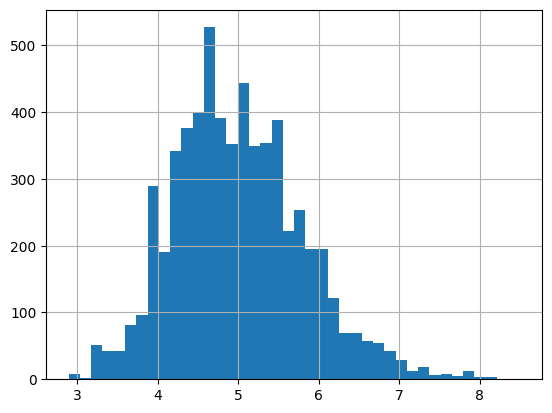

In [21]:
db.log_price.hist(bins=40)
plt.show()

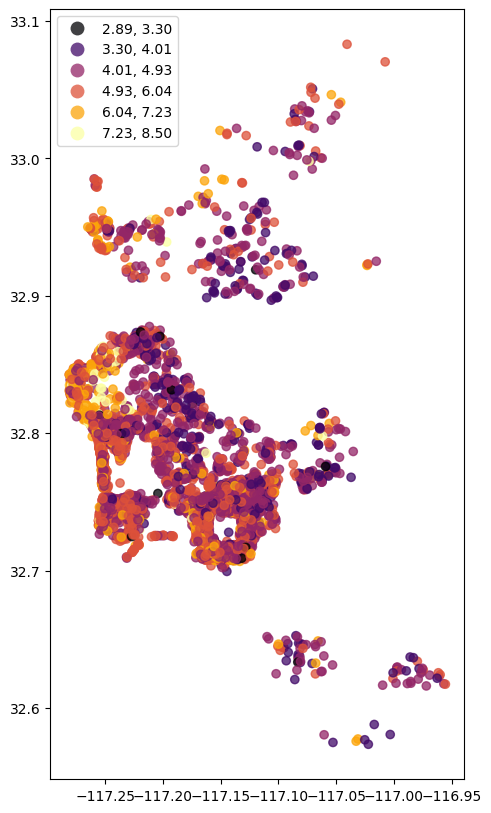

In [22]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
db.plot(
    column="log_price",
    cmap="inferno",
    scheme="percentiles",
    alpha=0.75,
    legend=True,
    ax=ax,
)
plt.show()

In [23]:
# knn = weights.KNN.from_dataframe(db, geom_col="geometry", k=20)
# A_20nn_sym = make_sym_matrix_boolean_sum(knn.full()[0])
# A_tilde_20nn_sym = renormalized_trick_mx(A_20nn_sym)
# Laplacian_knn = renormalized_trick_laplacian(A_tilde_20nn_sym)
laplacian_knn, knn = prepare_adjacency_matrix(db, 20)

/home/pdconte/.local/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [24]:
check_symmetric(laplacian_knn.numpy())

True

In [25]:
adj = torch.FloatTensor(laplacian_knn).to(device)

In [26]:
### The observations for data regression
x_tensor = torch.FloatTensor(db[variable_names].values.tolist()).to(device)
x_append_tensor = torch.FloatTensor(db[variable_names_append].values.tolist()).to(
    device
)
y_tensor = torch.FloatTensor(db[["log_price"]].values.tolist()).to(device)
idx_all = torch.LongTensor(db.index.values).to(device)

In [27]:
class ModelFactory:
    """Factory class to create different types of GCN models."""

    @staticmethod
    def create(
        model_type: str,
        in_features: int,
        out_features: int,
        hidden: list,
        dropouts: list,
    ) -> nn.Module:
        if model_type == "GCN":
            return GCN(in_features, out_features, hidden, dropouts).to(device)
        elif model_type == "GWGCN":
            return GWGCN(in_features, out_features, hidden, dropouts).to(device)
        else:
            raise ValueError(f"Unknown model type: {model_type}")

In [28]:
model_type = "GWGCN"  # or "GCN"
model = ModelFactory.create(
    model_type, n_features, n_labels, hidden=[8 * n_features], dropouts=[0.5]
)

In [29]:
# Define and train the model
#model = GWGCN(n_features, n_labels, hidden=[8 * n_features], dropouts=[0.5]).to(device)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), lr, weight_decay=lr*0.1
)
lowest_mean_global_error= np.inf
min_global_error_epoch = -1
train_loss_arr = []
error_arr = []

for i in range(epochs):
    train_loss = step(
        model, optimizer, x_tensor, idx_all, y_tensor, adj
    )  # For demo, train with all ids "idx_all"
    train_loss_arr.append(train_loss)
    global_error = evaluate_error(
        model, x_tensor, idx_all, y_tensor, adj, "MSE"
    )  # For demo, evaluate with again all ids "idx_all"
    error_arr.append(global_error )

    if global_error < lowest_mean_global_error:
        lowest_mean_global_error = global_error
        output, target = return_results(model, x_tensor, idx_all, y_tensor, adj)
        min_global_error_epoch = i

    if i % 1000 == 0 or i == epochs - 1:
        print("epoch:" + str(i) + "--train_loss:" + str(train_loss))
        print(" --global_error:" + "{:.4f}".format(global_error))

epoch:0--train_loss:95181.3203125
 --global_error:18683.5762
epoch:1000--train_loss:44610.49609375
 --global_error:8764.6621
epoch:2000--train_loss:23245.255859375
 --global_error:4559.2720
epoch:3000--train_loss:12498.0498046875
 --global_error:2489.8406
epoch:4000--train_loss:7073.7607421875
 --global_error:1385.7576
epoch:5000--train_loss:3928.489013671875
 --global_error:771.6622
epoch:6000--train_loss:2142.4052734375
 --global_error:424.6655
epoch:7000--train_loss:1172.405029296875
 --global_error:228.6645
epoch:8000--train_loss:615.4609375
 --global_error:119.4056
epoch:9000--train_loss:309.3077697753906
 --global_error:59.8406
epoch:10000--train_loss:149.7082977294922
 --global_error:28.4360
epoch:11000--train_loss:67.22911834716797
 --global_error:12.6900
epoch:12000--train_loss:28.564363479614258
 --global_error:5.3685
epoch:13000--train_loss:12.563375473022461
 --global_error:2.3563
epoch:14000--train_loss:7.157552719116211
 --global_error:1.3468
epoch:15000--train_loss:5.776

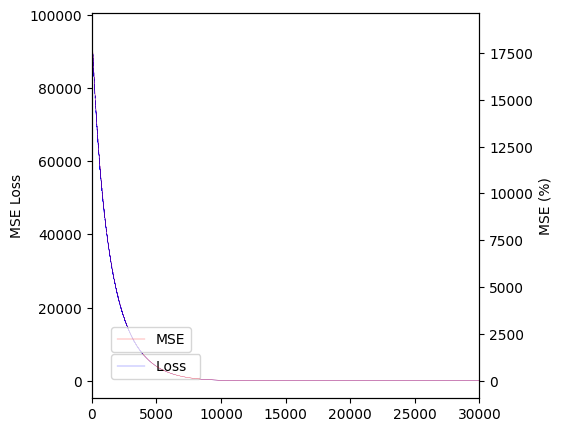

In [30]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(train_loss_arr, lw=0.2, color="b", alpha=1, label="Loss  ")
ax.set_xlim([0, 30000])
# ax.set_ylim([0, 0.8])
ax2 = ax.twinx()
ax2.plot(error_arr, lw=0.2, color="r", alpha=1, label="MSE")
# ax2.set_ylim([4, 14])
ax2.legend(loc=(0.05, 0.12))
ax.legend(loc=(0.05, 0.05))
ax.set_ylabel("MSE Loss")
ax2.set_ylabel("MSE (%)")
#plt.axvline(min_global_error_epoch, linestyle="dotted", linewidth=2, color="black")
plt.show()

In [31]:
error = (mse(output, target) / target).mean()
error  # mean absolute percentage error between predicted y and the real y

np.float32(0.16612996)

In [32]:
SSE = np.sum((target - output) ** 2)
SST = np.sum((db[["log_price"]].values - db[["log_price"]].values.mean()) ** 2)

Rsq = 1 - SSE / SST
Rsq  # R-square of model fit

np.float64(-0.24166779876296118)

In [33]:
Ierror = esda.moran.Moran(output - target, knn)
print(
    "Errors  moransI: "
    + str(Ierror.I)
    + "  Z_I: "
    + str(Ierror.z_norm)
    + " p-value: "
    + str(Ierror.p_sim)
)

Errors  moransI: 0.34930018866971096  Z_I: 91.16902112100612 p-value: 0.001


Text(0.5, 1.0, 'error')

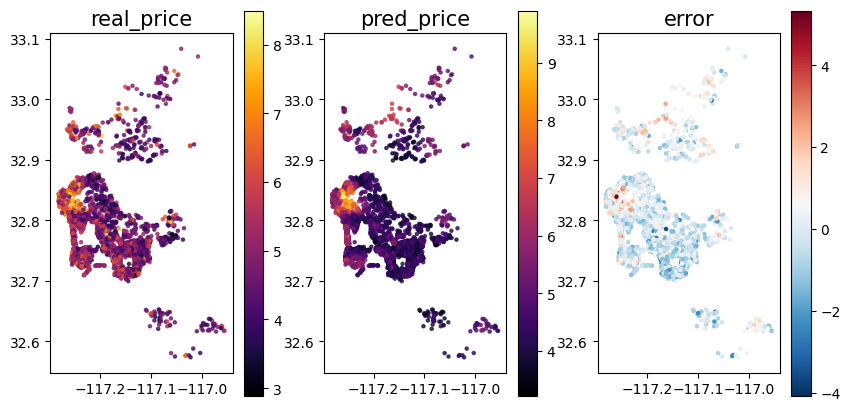

In [34]:
dbplot = db.loc[:, ["log_price", "geometry"]].copy()
dbplot["pred"] = output
dbplot["error"] = output - db[["log_price"]].values

f, ax = plt.subplots(1, 3, figsize=(10, 5))

dbplot.plot(column="log_price", cmap="inferno", s=5, alpha=0.75, legend=True, ax=ax[0])
dbplot.plot(column="pred", cmap="inferno", s=5, alpha=0.75, legend=True, ax=ax[1])
dbplot.plot(column="error", cmap="RdBu_r", s=5, alpha=1, legend=True, ax=ax[2])
ax[0].set_title("real_price", fontsize=15)
ax[1].set_title("pred_price", fontsize=15)
ax[2].set_title("error", fontsize=15)

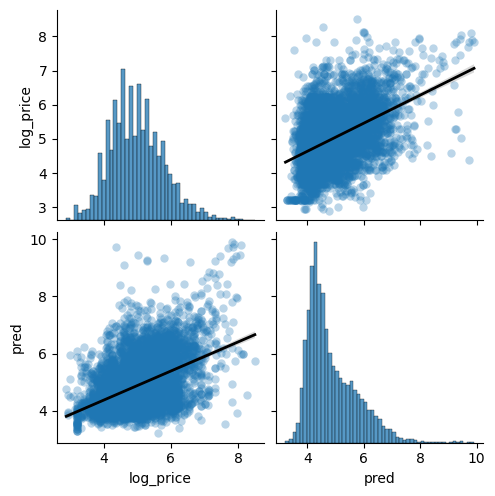

In [35]:
sns.pairplot(
    dbplot.drop("error", axis=1),
    diag_kind="hist",
    kind="reg",
    plot_kws={
        "line_kws": {"color": "black", "lw": 2},
        "scatter_kws": {"linewidths": 0, "alpha": 0.3},
    },
)
plt.show()

#### Referencias

* https://github.com/dizhu-gis/SRGCNN

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)